### Import statements

In [1]:
import fastai
print(fastai.__version__)

1.0.28


In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import os
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import scipy.optimize as opt
from sklearn.metrics import f1_score

import math
import cv2
import subprocess
from operator import itemgetter

In [3]:
np.random.seed(42)

In [4]:
path = Path('data')

In [5]:
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [7]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [8]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [9]:
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [10]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [11]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [12]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [13]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [14]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [15]:
src.add_test(test_fnames, label='0');

In [16]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [17]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [18]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

In [19]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

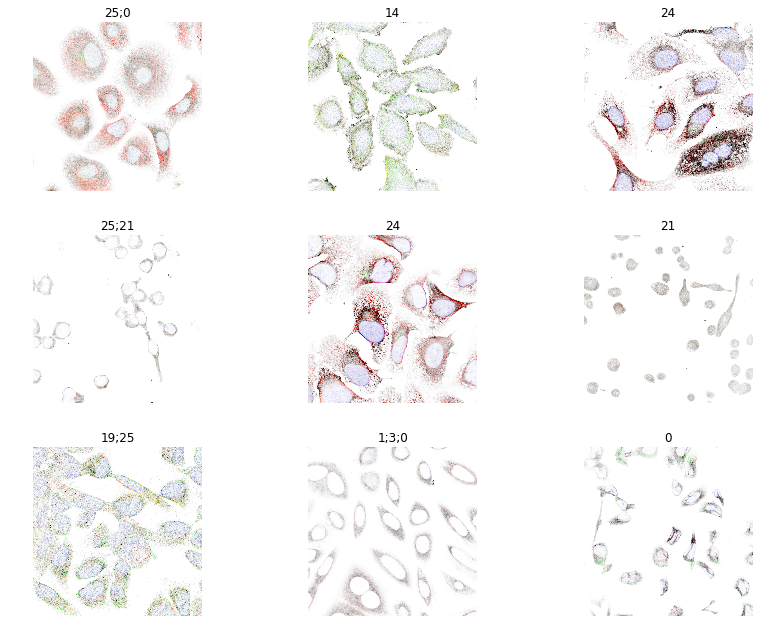

In [20]:
data.show_batch(rows=3, figsize=(12,9))

In [21]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [22]:
def _resnet_split(m): return (m[0][6],m[1])

In [23]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0.5, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
        
    def _sigmoid(self, inputs):
        return 1. / (1. + torch.exp(-inputs))

    def forward(self, inputs, targets):
        print("inputs:", inputs, "targets:", targets)
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        tmp = self._sigmoid(inputs)
        F_loss = (self.alpha * (1 - tmp) ** self.gamma) * BCE_loss
        print("F_loss:", F_loss, "BEC:", BCE_loss, "Multi:", (self.alpha * (1 - tmp) ** self.gamma))
        if self.reduce:
            print("mean loss:", torch.mean(F_loss))
            return torch.mean(F_loss)
        else:
            return F_loss

In [25]:
# Tensor binary_cross_entropy_with_logits(const Tensor& input, const Tensor& target, const Tensor& weight, const Tensor& pos_weight, int64_t reduction) {
#     Tensor loss;
#     auto max_val = (-input).clamp_min_(0);
#     if (pos_weight.defined()) {
#         // pos_weight need to be broadcasted, thus mul(target) is not inplace.
#         auto log_weight = (pos_weight - 1).mul(target).add_(1);
#         loss = (1 - target).mul_(input).add_(log_weight.mul_(((-max_val).exp_().add_((-input - max_val).exp_())).log_().add_(max_val)));
#     } else {
#         loss = (1 - target).mul_(input).add_(max_val).add_((-max_val).exp_().add_((-input -max_val).exp_()).log_());
#     }

#     if (weight.defined()) {
#         loss.mul_(weight);
#     }

#     return apply_loss_reduction(loss, reduction);
# }

class FocalLossStableLog(nn.Module):
    def __init__(self, gamma=0.5):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
#         print("loss:", loss.sum(dim=1).mean())
        return loss.sum(dim=1).mean()

In [26]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=FocalLossStableLog(),
    path=path,    
    metrics=[f1_score], 
)

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(2, 2e-2)

Total time: 15:10
epoch  train_loss  valid_loss  fbeta   
1      2.933496    2.901454    0.475622  (07:45)
2      2.278104    2.149747    0.594025  (07:25)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


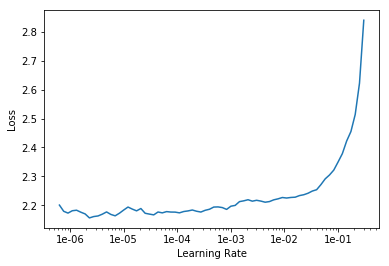

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(6, 1e-4)

Total time: 44:39
epoch  train_loss  valid_loss  fbeta   
1      2.183335    2.135779    0.598315  (07:23)
2      2.199366    2.120197    0.601025  (07:29)
3      2.177225    2.110675    0.604249  (07:26)
4      2.157013    2.099978    0.606576  (07:23)
5      2.153195    2.100527    0.609446  (07:26)
6      2.156246    2.098556    0.606000  (07:29)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


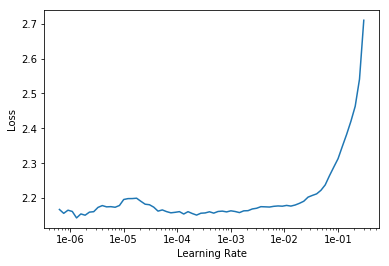

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(6, 1e-3)

Total time: 44:52
epoch  train_loss  valid_loss  fbeta   
1      2.154281    2.084841    0.609447  (07:29)
2      2.152168    2.069062    0.601310  (07:28)
3      2.079880    2.025347    0.617219  (07:28)
4      2.038130    1.987704    0.625067  (07:29)
5      2.008743    1.966708    0.629262  (07:28)
6      1.997296    1.965028    0.627995  (07:29)



In [37]:
learn.fit_one_cycle(10, 5e-3)

Total time: 1:14:43
epoch  train_loss  valid_loss  fbeta   
1      2.028183    2.081745    0.592113  (07:28)
2      2.092568    2.150458    0.601434  (07:28)
3      2.125770    2.203192    0.569859  (07:28)
4      2.070414    2.200090    0.587782  (07:28)
5      2.038258    2.056788    0.607692  (07:28)
6      1.966069    2.125615    0.614670  (07:28)
7      1.913700    1.941162    0.636953  (07:28)
8      1.862452    1.856243    0.642442  (07:28)
9      1.794075    1.830815    0.655507  (07:28)
10     1.778873    1.826042    0.655860  (07:28)



In [28]:
learn.fit_one_cycle(12, 1e-4)

Total time: 1:29:47
epoch  train_loss  valid_loss  fbeta   
1      1.771579    1.825947    0.654145  (07:43)
2      1.768064    1.824448    0.656086  (07:27)
3      1.765693    1.821813    0.655397  (07:28)
4      1.769138    1.816624    0.654309  (07:27)
5      1.762041    1.818475    0.655746  (07:28)
6      1.760243    1.814501    0.658347  (07:27)
7      1.760845    1.816999    0.660040  (07:27)
8      1.753939    1.817083    0.658388  (07:27)
9      1.751892    1.815504    0.656484  (07:27)
10     1.758812    1.818311    0.658650  (07:27)
11     1.766441    1.815766    0.657757  (07:27)
12     1.768175    1.816929    0.656283  (07:26)



In [27]:
_ = learn.load("tmp2")

In [28]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


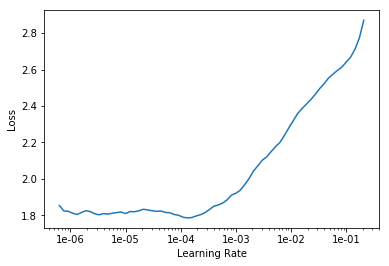

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(6, slice(1e-6, 5e-5))

Total time: 58:44
epoch  train_loss  valid_loss  fbeta   
1      1.814800    1.822520    0.653887  (09:59)
2      1.798105    1.820809    0.654654  (09:45)
3      1.765040    1.809292    0.654715  (09:45)
4      1.727224    1.802590    0.659802  (09:45)
5      1.716867    1.799908    0.660439  (09:44)
6      1.708774    1.797817    0.657123  (09:45)



In [31]:
learn.save("unfreeze-224-focal-loss-0.25-gamma")

In [27]:
_ = learn.load("unfreeze-224-focal-loss-0.25-gamma")

In [28]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


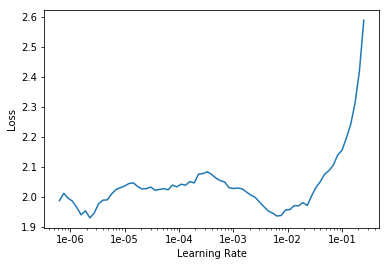

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(10, 1e-3)

Total time: 3:54:44
epoch  train_loss  valid_loss  fbeta   
1      1.805460    1.692907    0.681714  (23:52)
2      1.796390    1.667458    0.680888  (23:27)
3      1.711624    1.678312    0.685989  (23:25)
4      1.719652    1.658099    0.688183  (23:24)
5      1.662320    1.626653    0.688198  (23:26)
6      1.663036    1.627698    0.700480  (23:26)
7      1.620443    1.608524    0.708104  (23:25)
8      1.586782    1.578741    0.707012  (23:25)
9      1.569326    1.566817    0.707138  (23:25)
10     1.556781    1.568323    0.704725  (23:25)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


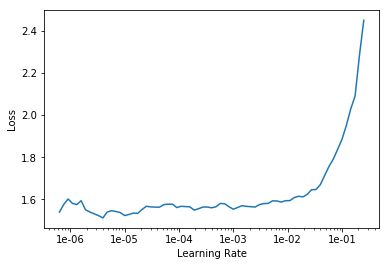

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(12, 1e-4)

Total time: 4:41:11
epoch  train_loss  valid_loss  fbeta   
1      1.585430    1.569808    0.710437  (23:26)
2      1.561593    1.571543    0.708557  (23:25)
3      1.576408    1.561460    0.707594  (23:26)
4      1.570810    1.561761    0.709174  (23:26)
5      1.568227    1.565398    0.712138  (23:25)
6      1.545250    1.566534    0.711516  (23:25)
7      1.587634    1.562893    0.711761  (23:26)
8      1.545364    1.557261    0.706785  (23:25)
9      1.543350    1.564159    0.709284  (23:26)
10     1.499515    1.555955    0.707366  (23:25)
11     1.553286    1.554302    0.710197  (23:25)
12     1.526119    1.558725    0.706756  (23:25)



In [33]:
learn.save("freeze-386-focal-loss-0.25-gamma")

In [27]:
_ = learn.load("freeze-386-focal-loss-0.25-gamma")

In [28]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


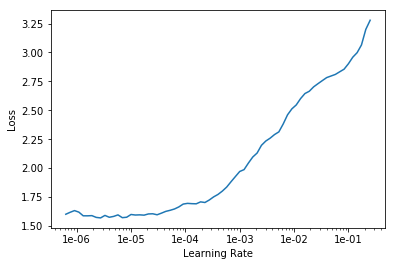

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5))

Total time: 5:06:38
epoch  train_loss  valid_loss  fbeta   
1      1.532328    1.564811    0.713248  (31:12)
2      1.554374    1.553814    0.705181  (30:41)
3      1.542024    1.557999    0.713312  (30:41)
4      1.520084    1.548600    0.709282  (30:39)
5      1.486564    1.542625    0.710729  (30:30)
6      1.547897    1.546542    0.710713  (30:30)
7      1.552923    1.538117    0.713785  (30:30)
8      1.512398    1.536804    0.711848  (30:38)
9      1.478639    1.533377    0.710905  (30:41)
10     1.517916    1.533495    0.710055  (30:32)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


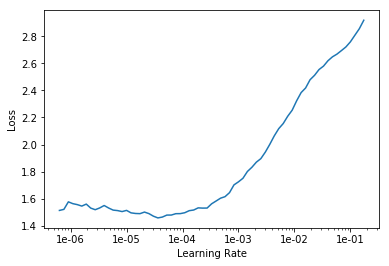

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(10, slice(1e-7, 5e-5))

Total time: 5:05:08
epoch  train_loss  valid_loss  fbeta   
1      1.474423    1.534209    0.714947  (30:30)
2      1.509537    1.535959    0.714178  (30:31)
3      1.516163    1.535281    0.713078  (30:30)
4      1.517214    1.535872    0.716280  (30:31)
5      1.500214    1.530938    0.712256  (30:30)
6      1.493716    1.524852    0.714419  (30:30)
7      1.470012    1.532515    0.715798  (30:31)
8      1.501952    1.524631    0.714423  (30:30)
9      1.466967    1.543984    0.716602  (30:30)
10     1.500358    1.529496    0.721916  (30:30)



In [34]:
learn.save("unfreeze-386-focal-loss-0.25-gamma")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


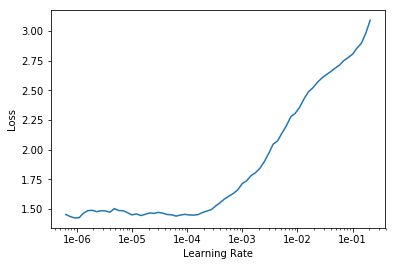

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(10, slice(1e-8, 1e-6))

Total time: 5:05:12
epoch  train_loss  valid_loss  fbeta   
1      1.454274    1.525629    0.709827  (30:30)
2      1.448285    1.516921    0.714489  (30:31)
3      1.427418    1.532497    0.716496  (30:30)
4      1.457631    1.526635    0.719385  (30:31)
5      1.461906    1.527080    0.720125  (30:31)
6      1.485842    1.524915    0.714518  (30:31)
7      1.478968    1.521811    0.717154  (30:31)
8      1.470454    1.519153    0.712500  (30:31)
9      1.438279    1.519512    0.709515  (30:31)
10     1.433978    1.523214    0.719753  (30:31)



In [37]:
learn.save("unfreeze-386-focal-loss-0.25-gamma-2")

In [27]:
_ = learn.load("unfreeze-386-focal-loss-0.25-gamma-2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


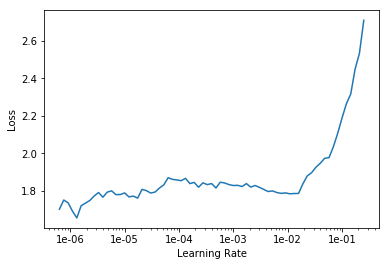

In [28]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, 1e-5)

epoch,train_loss,valid_loss,fbeta
1,1.855323,1.784102,0.676631
2,1.747756,1.720974,0.682664


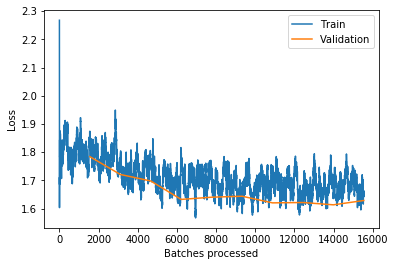

In [29]:
learn.recorder.plot_losses()

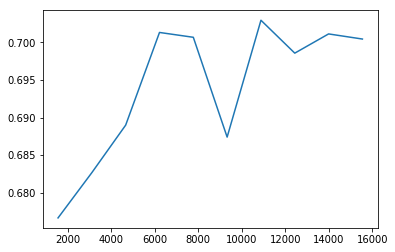

In [30]:
learn.recorder.plot_metrics()

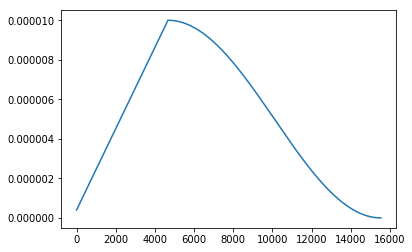

In [31]:
learn.recorder.plot_lr()

In [32]:
learn.save("freeze-512-focal-loss-0.25-gamma")

In [33]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


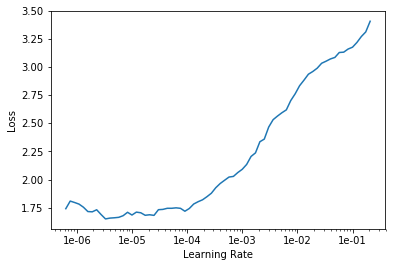

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(10, max_lr=slice(1e-7, 1e-5))

Total time: 7:08:04
epoch  train_loss  valid_loss  fbeta   
1      1.617878    1.618318    0.704267  (42:47)
2      1.660623    1.593085    0.708913  (42:44)
3      1.751697    1.576153    0.712854  (42:43)
4      1.655566    1.570690    0.710697  (42:49)
5      1.621474    1.568470    0.698721  (42:50)
6      1.589048    1.560976    0.711424  (42:49)
7      1.661193    1.556695    0.711996  (42:49)
8      1.611531    1.549626    0.705766  (42:50)
9      1.587868    1.545989    0.709920  (42:49)
10     1.674148    1.547189    0.711702  (42:49)



In [36]:
learn.save("unfreeze-512-focal-loss-0.25-gamma")

In [27]:
_ = learn.load("unfreeze-512-focal-loss-0.25-gamma")

In [32]:
preds,_ = learn.get_preds(DatasetType.Test)

In [28]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)


Total time: 54:57



In [33]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
# df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,


In [34]:
df.to_csv(path / 'focal_loss_gamma_0.25_512_unfreeze-no-tta.csv', header=True, index=False)

In [37]:
learn.fit_one_cycle(15, max_lr=slice(1e-10, 1e-7))

epoch,train_loss,valid_loss,fbeta
1,1.613381,1.547626,0.709234
2,1.566978,1.558271,0.711548
3,1.589620,1.549873,0.709186
4,1.573101,1.563538,0.705515


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 